In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

In [3]:
air = pd.read_excel("Airlines+Data.xlsx") 
air

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
air.isna().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
air.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


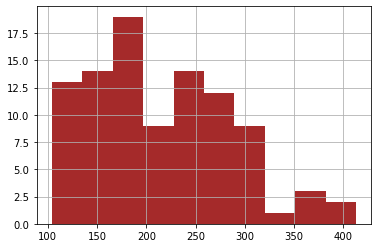

In [8]:
air['Passengers'].hist(color='brown');

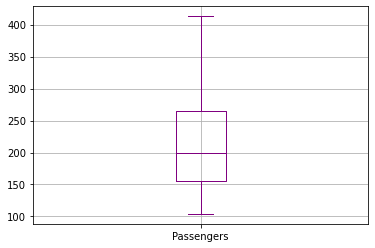

In [49]:
air.boxplot(color='Purple')

In [50]:
air.rename(columns={"Passengers ('000)":"Passengers"},inplace=True)

### Time Series 

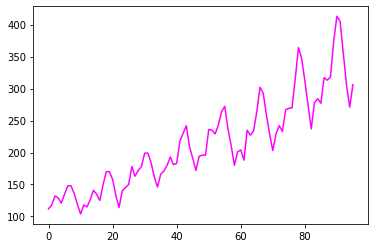

In [51]:
air.Passengers.plot(color='magenta'); # time series plot 

In [52]:
air.index = pd.to_datetime(air.Month,format="%b-%y")
air['year'] = pd.DatetimeIndex(air['Month']).year
air['month'] = pd.DatetimeIndex(air['Month']).month
air['year']

Month
1995-01-01    1995
1995-02-01    1995
1995-03-01    1995
1995-04-01    1995
1995-05-01    1995
              ... 
2002-08-01    2002
2002-09-01    2002
2002-10-01    2002
2002-11-01    2002
2002-12-01    2002
Name: year, Length: 96, dtype: int64

In [53]:
air['month']

Month
1995-01-01     1
1995-02-01     2
1995-03-01     3
1995-04-01     4
1995-05-01     5
              ..
2002-08-01     8
2002-09-01     9
2002-10-01    10
2002-11-01    11
2002-12-01    12
Name: month, Length: 96, dtype: int64

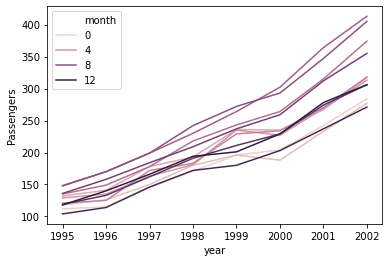

In [54]:
sns.lineplot(x="year",y="Passengers",hue="month",data=air)

# Data Driven Model

### Moving Average

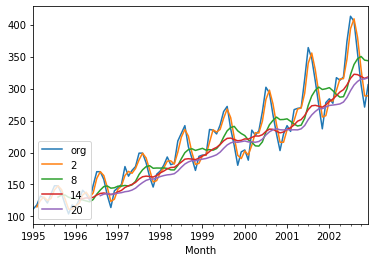

In [55]:
# moving average for the time series to understand better about the trend character 
air.Passengers.plot(label="org")
for i in range(2,24,6):
    air["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

### Time Series Decomposition 

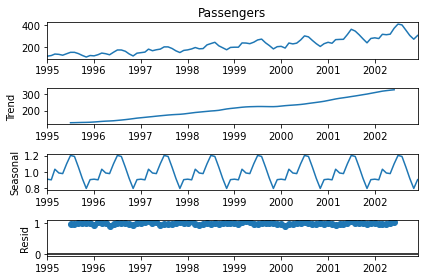

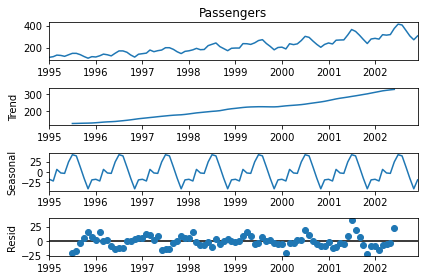

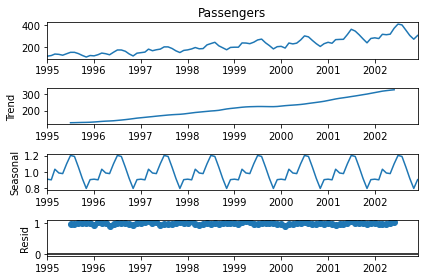

In [56]:
# Time series decomposition plot 

decompose_ts_add = seasonal_decompose(air.Passengers,model="additive")
decompose_ts_add.plot()
decompose_ts_mul = seasonal_decompose(air.Passengers,model="multiplicative")
decompose_ts_mul.plot()

### ACF Plots and PACF Plots 

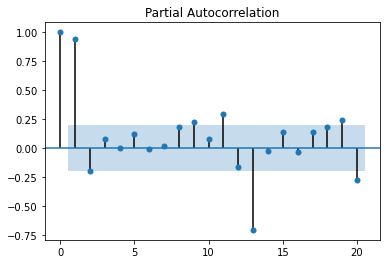

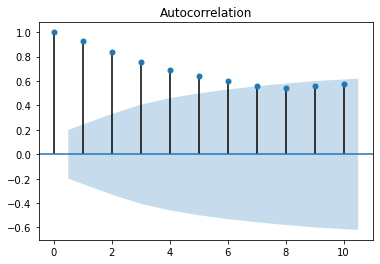

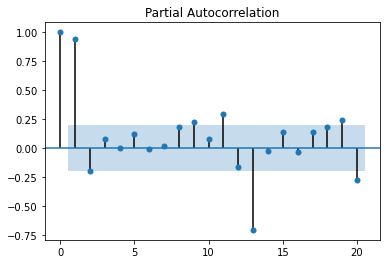

In [57]:
# ACF plots and PACF plots on Original data sets 
tsa_plots.plot_acf(air.Passengers,lags=10)
tsa_plots.plot_pacf(air.Passengers)

In [58]:
# Splitting data
Train = air.head(80)
Test = air.tail(16)

In [59]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)


#### Exponential Method

In [60]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Passengers) 

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


17.538105123502607

#### Holt Method

In [61]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Passengers) 

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


22.177768220915112

####  Holts winter exponential smoothing with additive seasonality and additive trend

In [62]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Passengers)

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


9.050242551660086

####  Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [63]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Passengers)

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


3.217195574703948

## Data Driven Final Model 

In [64]:
hwe_model_add_add = ExponentialSmoothing(air["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [218]:
hwe_model_add_add.forecast(70)

2003-01-01    320.924021
2003-02-01    313.638039
2003-03-01    352.925020
2003-04-01    350.350301
2003-05-01    356.060922
                 ...    
2008-06-01    584.828407
2008-07-01    622.072392
2008-08-01    609.287304
2008-09-01    558.691737
2008-10-01    512.099532
Freq: MS, Length: 70, dtype: float64

# Model Based Approach

In [133]:
air = pd.read_excel("Airlines+Data.xlsx")
month =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] 
import numpy as np
p= air["Month"][0]
air['months']=0
for i in range(96):
    p = air["Month"][i]
    air['months'][i]
month_dummies = pd.DataFrame(pd.get_dummies(air['months']))
air1 = pd.concat([air,month_dummies],axis = 1)

air1["t"] = np.arange(1,97)

air1["t_squared"] = air1["t"]*air1["t"]
air1.columns
air1["log_Rider"] = np.log(air1["Passengers"])
air1.rename(columns={"Passengers": 'passengers'}, inplace=True)

        Month  passengers  months  0   t  t_squared  log_Rider
0  1995-01-01         112       0  1   1          1   4.718499
1  1995-02-01         118       0  1   2          4   4.770685
2  1995-03-01         132       0  1   3          9   4.882802
3  1995-04-01         129       0  1   4         16   4.859812
4  1995-05-01         121       0  1   5         25   4.795791
..        ...         ...     ... ..  ..        ...        ...
91 2002-08-01         405       0  1  92       8464   6.003887
92 2002-09-01         355       0  1  93       8649   5.872118
93 2002-10-01         306       0  1  94       8836   5.723585
94 2002-11-01         271       0  1  95       9025   5.602119
95 2002-12-01         306       0  1  96       9216   5.723585

[96 rows x 7 columns]


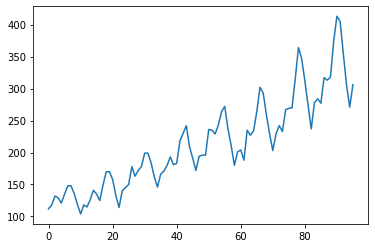

In [134]:
Train = air1.head(80)
Test = air1.tail(16)
print(air1)
air1.passengers.plot()

In [171]:
air1["Date"] = pd.to_datetime(air1.Month,format="%b-%y")
air1["month"] = air1.Date.dt.strftime("%b") # month extraction
air1["year"] = air1.Date.dt.strftime("%Y") # year extraction
Train1 = air.head(80)
Test1 = air.tail(16)
air1

,Month,passengers,months,0,t,t_squared,log_Rider,Date,month,year
0,1995-01-01,112,0,1,1,1,4.718499,1995-01-01,Jan,1995
1,1995-02-01,118,0,1,2,4,4.770685,1995-02-01,Feb,1995
2,1995-03-01,132,0,1,3,9,4.882802,1995-03-01,Mar,1995
3,1995-04-01,129,0,1,4,16,4.859812,1995-04-01,Apr,1995
4,1995-05-01,121,0,1,5,25,4.795791,1995-05-01,May,1995
...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,0,1,92,8464,6.003887,2002-08-01,Aug,2002
92,2002-09-01,355,0,1,93,8649,5.872118,2002-09-01,Sep,2002
93,2002-10-01,306,0,1,94,8836,5.723585,2002-10-01,Oct,2002
94,2002-11-01,271,0,1,95,9025,5.602119,2002-11-01,Nov,2002


### Heat Map 

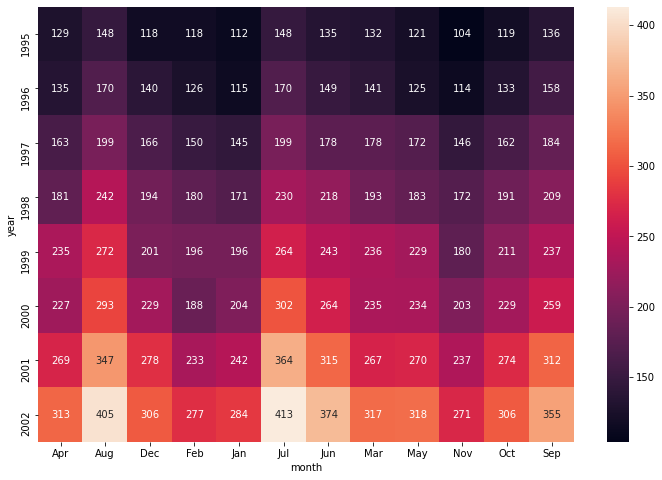

In [152]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=air1,values="passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

### Boxplots 

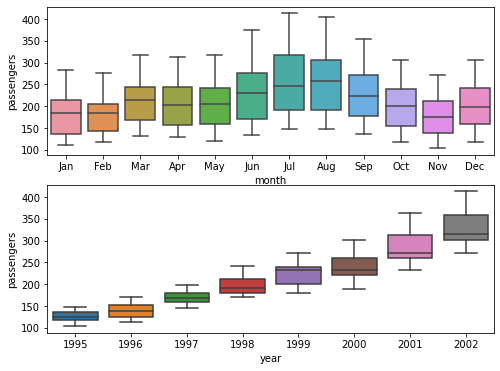

In [153]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="passengers",data=air1)
plt.subplot(212)
sns.boxplot(x="year",y="passengers",data=air1)

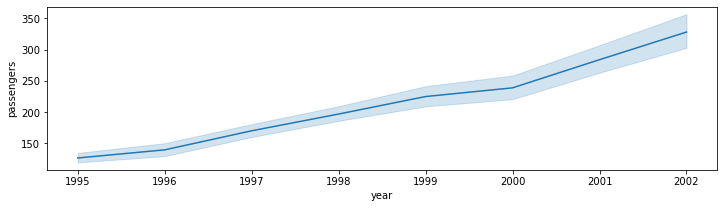

In [154]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="passengers",data=air1)

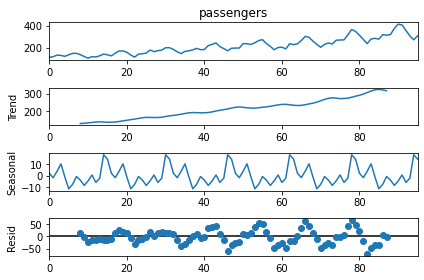

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(air1.passengers,period=16)
decompose_ts_add.plot()
plt.show() 

#### Linear Model

In [156]:
import statsmodels.formula.api as smf 
linear_model = smf.ols('passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_linear))**2)) 
rmse_linear

47.542624067726734

####  Exponential

In [157]:
Exp = smf.ols('log_Rider~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp 

43.793739393343294

#### Quadratic 

In [158]:
Quad = smf.ols('passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['passengers'])-np.array(pred_Quad))**2))
rmse_Quad 

43.65440369584208

#### Additive Seasonality 

In [177]:
add_sea = smf.ols('Passengers~months',data=Train1).fit()
pred_add_sea = pd.Series(add_sea.predict(Test1[['months']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test1['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea 

130.58484789591787

In [194]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

,MODEL,RMSE_Values
2,rmse_Quad,43.654404
1,rmse_Exp,43.793739
0,rmse_linear,47.542624
3,rmse_add_sea,130.584848


In [208]:
predict_data = pd.read_csv("Predict_new (2).csv")   

In [209]:
predict_data  

,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,t,t_squared
0,04-Apr,0,0,0,1,0,0,0,0,0,0,0,0,160,25600
1,04-May,0,0,0,0,1,0,0,0,0,0,0,0,161,25921
2,04-Jun,0,0,0,0,0,1,0,0,0,0,0,0,162,26244
3,04-Jul,0,0,0,0,0,0,1,0,0,0,0,0,163,26569
4,04-Aug,0,0,0,0,0,0,0,1,0,0,0,0,164,26896
5,04-Sep,0,0,0,0,0,0,0,0,1,0,0,0,165,27225
6,04-Oct,0,0,0,0,0,0,0,0,0,1,0,0,166,27556
7,04-Nov,0,0,0,0,0,0,0,0,0,0,1,0,167,27889
8,04-Dec,0,0,0,0,0,0,0,0,0,0,0,1,168,28224
9,05-Jan,1,0,0,0,0,0,0,0,0,0,0,0,169,28561


In [210]:
model_full = smf.ols('passengers~t+t_squared',data=air1).fit()   

In [212]:
pred_new  = pd.Series(Quad.predict(predict_data)) 
pred_new

0     610.073961
1     614.984261
2     619.917351
3     624.873230
4     629.851899
5     634.853357
6     639.877604
7     644.924641
8     649.994467
9     655.087082
10    660.202487
11    665.340681
dtype: float64

In [214]:
predict_data["forecasted_Airlines"] = pd.Series(pred_new) 
predict_data

,Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,t,t_squared,forecasted_Airlines
0,04-Apr,0,0,0,1,0,0,0,0,0,0,0,0,160,25600,610.073961
1,04-May,0,0,0,0,1,0,0,0,0,0,0,0,161,25921,614.984261
2,04-Jun,0,0,0,0,0,1,0,0,0,0,0,0,162,26244,619.917351
3,04-Jul,0,0,0,0,0,0,1,0,0,0,0,0,163,26569,624.873230
4,04-Aug,0,0,0,0,0,0,0,1,0,0,0,0,164,26896,629.851899
5,04-Sep,0,0,0,0,0,0,0,0,1,0,0,0,165,27225,634.853357
6,04-Oct,0,0,0,0,0,0,0,0,0,1,0,0,166,27556,639.877604
7,04-Nov,0,0,0,0,0,0,0,0,0,0,1,0,167,27889,644.924641
8,04-Dec,0,0,0,0,0,0,0,0,0,0,0,1,168,28224,649.994467
9,05-Jan,1,0,0,0,0,0,0,0,0,0,0,0,169,28561,655.087082
